# ESPPy - The Python Interface to ESP

This interface is a pure Python package to connect to ESP using the REST interface and web sockets.

## Import the ESP Package and Create a Connection

In [2]:
import esppy

In [3]:
esppy.ESP?

In [4]:
esp = esppy.ESP('http://v64-d79221-03:8610')
esp

ESP('http://v64-d79221-03:8610')

In [ ]:
esp.

## Server Introspection

In [8]:
esp.server_info

{'analytics-license': True,
 'engine': 'esp',
 'http': 8610,
 'plugindir': '/sasgen/dev/mva-vb015/sasdvd/com/laxnd',
 'pubsub': 8611,
 'version': '5.2'}

In [9]:
esp.get_projects()

{}

## Load a Project

In [12]:
%%sh
cat model_walking.xml

<engine>
  <projects>
    <project name='project' pubsub='auto' threads='1' use-tagged-token='true'>
      <contqueries>
        <contquery name='contquery' trace='w_data w_calculate'>
          <windows>
            <window-source name='w_data' insert-only='true'>
              <schema>
                <fields>
                  <field name='id'   type='int64' key='true'/>
                  <field name='time' type='double'/>
                  <field name='x'    type='double'/>
                  <field name='y'    type='double'/>
                  <field name='z'    type='double'/>
                </fields>
              </schema>
            </window-source>
            <window-source name='w_request' insert-only='true'>
              <schema>
                <fields>
                  <field name='req_id'  type='int64' key='true'/>
                  <field name='req_key' type='string'/>
                  <field name='req_val' type='string'/>
                </fields>
              </

Projects can be loaded from file paths, Python file objects, or URLs.  They can also be loaded from Python `Project` objects as we will see later in this notebook.

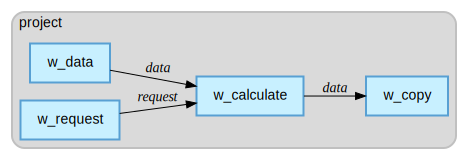

In [13]:
walk = esp.load_project('model_walking.xml')
walk

In [14]:
str(walk)

"Project(name='project')"

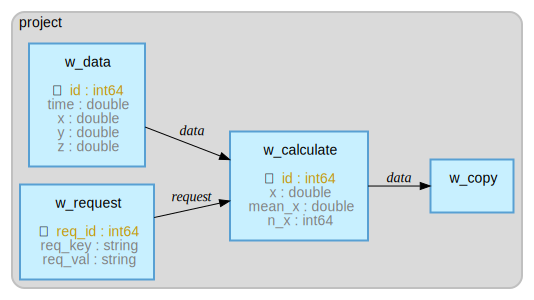

In [15]:
walk.to_graph(schema=True)

### Get References to Project Components

In [16]:
walk.queries

{'contquery': ContinuousQuery(name='contquery', project='project')}

In [17]:
walk.queries['contquery'].windows

{'w_calculate': CalculateWindow(name='w_calculate', contquery='contquery', project='project'), 'w_copy': CopyWindow(name='w_copy', contquery='contquery', project='project'), 'w_request': SourceWindow(name='w_request', contquery='contquery', project='project'), 'w_data': SourceWindow(name='w_data', contquery='contquery', project='project')}

Specifying `queries` and `windows` is optional.  The `Project` and `ContinuousQuery` objects act like dictionaries so you can access the sub-objects directly using indexing. 

In [18]:
dataw = walk.queries['contquery'].windows['w_data']
calcw = walk['contquery']['w_calculate']
copyw = walk['contquery']['w_copy']

In [19]:
str(dataw)

"SourceWindow(name='w_data', contquery='contquery', project='project')"

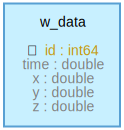

In [20]:
dataw.to_graph()

In [21]:
dataw.

SyntaxError: invalid syntax (<ipython-input-21-0a8d820cec1f>, line 1)

## Event Generators

In [22]:
%%sh
head model_walking.csv

I,N,1,0,0.69464,3.1735,7.5048
I,N,2,0.030639,0.14982,3.4868,9.2755
I,N,3,0.069763,-0.29965,1.9477,9.112
I,N,4,0.099823,-1.6889,1.4165,10.12
I,N,5,0.12982,-2.1793,0.95342,10.924
I,N,6,0.15979,-2.3018,0.23155,10.651
I,N,7,0.18982,-1.4165,1.185,11.073
I,N,8,0.2204,-0.27241,2.2201,11.986
I,N,9,0.24976,-0.61292,2.2201,11.986
I,N,10,0.27972,1.3348,4.2495,11.414


In [31]:
import os

# Using a URL path means the file must be accesible on the server-side
egen = dataw.create_event_generator('file:///%s' % os.path.abspath('model_walking.csv'))
egen

EventGenerator(name='eg_cb53ar8rw1', publish_target='dfESP://v64-d79221-03:8611/project/contquery/w_data')

In [32]:
egen.start(pause=200)

## Streaming DataFrames

In [33]:
dataw.subscribe(limit=20)

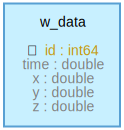

In [34]:
dataw

### Using DataFrame Plotting Features

In [35]:
%matplotlib inline

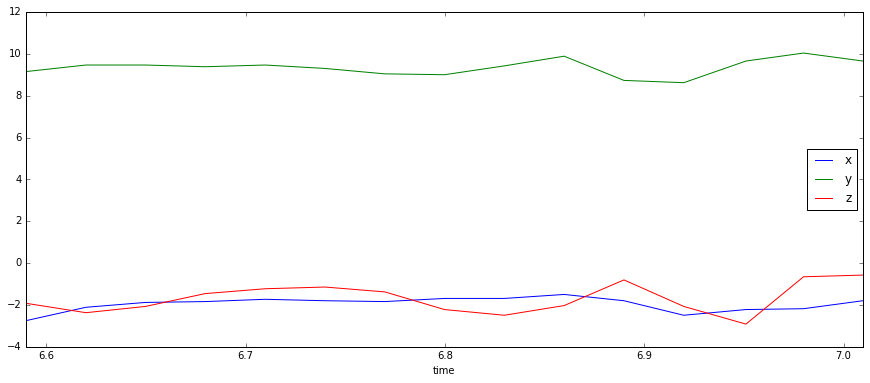

In [36]:
dataw.sort_values('time', ascending=True).plot('time', ['x', 'y', 'z'], figsize=(15, 6))

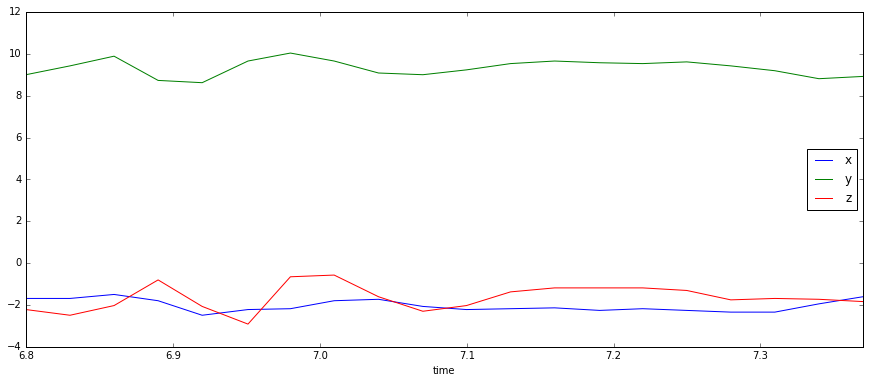

In [37]:
dataw.sort_values('time', ascending=True).plot('time', ['x', 'y', 'z'], figsize=(15, 6))

## Streaming Figures

In [38]:
dataw.streaming_line('time', ['x', 'y', 'z'], 
                     label=['X', 'Y', 'Z'],
                     y_range=(-16,16),
                     max_data=20, steps=1000, interval=100)

## Create a New Project Programmatically

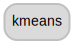

In [5]:
proj = esp.create_project('kmeans')
proj

### Add a Source Window

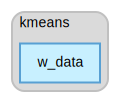

In [6]:
src = esp.SourceWindow(schema=('id*:int64', 'x_c:double', 'y_c:double'),
                       index_type='pi_EMPTY', insert_only=True)
proj.windows['w_data'] = src
proj

### Add a Training Window

In [ ]:
esp.train.

In [69]:
esp.train.KMEANS?

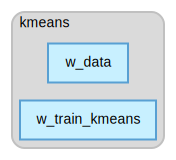

In [7]:
train = esp.train.KMEANS(
    velocity=5, fadeOutFactor=0.05, nClusters=2, dampingFactor=0.8, 
    nInit=50, commitInterval=25, initSeed=1, disturbFactor=0.01,
    input_map=dict(inputs=('x_c', 'y_c')))
proj.windows['w_train_kmeans'] = train
proj

### Add a Scoring Window

In [ ]:
esp.score.

In [9]:
esp.score.KMEANS?

In [11]:
esp.score.KMEANS.output_map_types

{'labelOut': 'int32', 'minDistanceOut': 'double', 'modelIdOut': 'int64'}

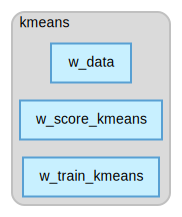

In [12]:
score = esp.score.KMEANS(
    schema=('id*:int64', 'x_c:double', 'y_c:double', 'min_dist:double', 'seg:int32', 'model_id:int64'),
    input_map=dict(inputs=('x_c', 'y_c')),
    output_map=dict(minDistanceOut='min_dist', labelOut='seg', modelIdOut='model_id')
)
proj.windows['w_score_kmeans'] = score
proj

### Make Connection Between Windows

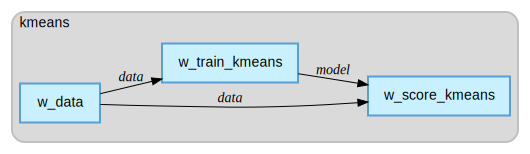

In [13]:
src.add_target(score, role='data')
src.add_target(train, role='data')
train.add_target(score, role='model')
proj

### Preview the Project's XML Definition

In [14]:
print(proj.to_xml(pretty=True))

<engine>
  <projects>
    <project name="kmeans" pubsub="auto" threads="1">
      <contqueries>
        <contquery name="contquery">
          <windows>
            <window-source index="pi_EMPTY" insert-only="true" name="w_data">
              <schema>
                <fields>
                  <field key="true" name="id" type="int64" />
                  <field key="false" name="x_c" type="double" />
                  <field key="false" name="y_c" type="double" />
                </fields>
              </schema>
            </window-source>
            <window-score name="w_score_kmeans">
              <schema>
                <fields>
                  <field key="true" name="id" type="int64" />
                  <field key="false" name="x_c" type="double" />
                  <field key="false" name="y_c" type="double" />
                  <field key="false" name="min_dist" type="double" />
                  <field key="false" name="seg" type="int32" />
                  <field ke

### Display a Graph of the Project

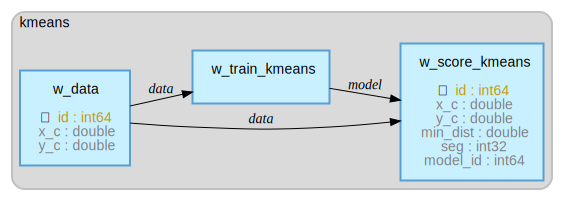

In [15]:
proj.to_graph(schema=True)

## Load the Project into the Server

In [16]:
esp.load_project(proj);

In [17]:
esp.get_projects()

{'kmeans': Project(name='kmeans')}

### Publish Events to Source Window

In [18]:
%%sh
head basics.csv

i,n,0,0.5908967210216602,1.6751986326790076
i,n,1,19.043415721883388,18.371355627504236
i,n,2,-0.012273367464207865,-0.4540492269435668
i,n,3,17.97874517980503,21.65120582597203
i,n,4,1.1659924204397523,-1.2409508065225885
i,n,5,0.8546216190275081,-0.25882119862607184
i,n,6,20.190217162336587,22.50997309914134
i,n,7,-0.25895458090747875,1.4976085871983391
i,n,8,22.29022654822051,16.914962015510373
i,n,9,20.77677573497869,19.816778938696523


Use pandas to transform data before publishing it.  Notice that the DataFrame can contain additional columns, and columns out-of-order.  Only the columns in the DataFrame that match the columns in the window schema are uploaded.

In [19]:
import pandas as pd

df = pd.read_csv('basics.csv', header=None, names=['opcode', 'opmode', 'id', 'x_c', 'y_c'])

df['extra'] = df['x_c']**2 + df['y_c']**2
df = df[['id', 'y_c', 'extra', 'x_c', 'opcode', 'opmode']]
df = df.set_index('id')

df.head()

,y_c,extra,x_c,opcode,opmode
id,,,,,
0,1.675199,3.155449,0.590897,i,n
1,18.371356,700.158390,19.043416,i,n
2,-0.454049,0.206311,-0.012273,i,n
3,21.651206,792.009992,17.978745,i,n
4,-1.240951,2.899497,1.165992,i,n


In [20]:
src.publish_events(df, pause=200)

In [21]:
src.subscribe()
score.subscribe()

In [22]:
src.tail(10)

,x_c,y_c
id,,
4,1.165992,-1.240951
5,0.854622,-0.258821
6,20.190217,22.509973
7,-0.258955,1.497609
8,22.290227,16.914962
9,20.776776,19.816779
10,20.325394,19.877868
11,17.925022,20.062600
12,-1.183328,0.720395


In [27]:
score.tail(10)

,x_c,y_c,min_dist,seg,model_id
id,,,,,
66,20.441177,23.336311,13.688857,1,0
67,20.247112,21.950957,12.469037,1,0
68,-1.755390,-0.435286,10.250279,0,0
69,18.746671,20.435761,10.350252,1,0
70,19.973171,20.472298,11.168066,1,0
71,18.948372,21.494872,11.322848,1,0
72,20.775433,20.093768,11.462084,1,0
73,0.631942,1.590953,7.119088,0,0
74,21.130736,19.050049,11.050893,1,0


## Plot the Streaming Data

This function is used to generate the legend and colors for each of the `x_c` / `y_c` data points.

In [28]:
class_map = dict(
    seg=dict(
        class_label={0: 'Class 1', 1: 'Class 2'},
        class_color={0: '#68b0e3b2', 1: '#d37a2db2'},
    )   
)

# Alternatively
def class_map_func(event):
    seg = event['seg']
    return dict(
        class_label=seg.map({0: 'Class 1', 1: 'Class 2'}),
        class_color=seg.map({0: '#68b0e3b2', 1: '#d37a2db2'}),
    )

Start the streaming scatter plot.

In [29]:
left_total = 0
right_total = 0
def map_left_right(event):
    global left_total, right_total
    out = dict(type=[], total=[])
    for rec in event.to_records(index=False):
        if r[0]:
            left_total += 1
            out['type'].append('left')
            out['total'].append(left_total)
        if r[1]:
            right_total += 1
            out['type'].append('right')
            out['total'].append(right_total)
    return

In [30]:
score.streaming_scatter('x_c', 'y_c', var_generator=class_map_func,
                        label='var(class_label)', fill_color='var(class_color)',
                        color='var(class_color)', point_radius=15,
                        y_range=(-15,30), x_range=(-15,30), 
                        max_data=35, steps=1000, interval=200,
                        x_axis_label='X', y_axis_label='Y')

## Client-side Transformers

Transformers can be any DataFrame operation.

In [31]:
score.add_event_transformer('abs')
score.add_event_transformer('clip', upper=20)

Or, they can be functions that can do any arbitrary operation.

In [32]:
def dist_group(event):
    event['dist_group'] = event['min_dist'] > 10
    return event

score.add_event_transformer(dist_group)

In [33]:
score.head(10)

,x_c,y_c,min_dist,seg,model_id,dist_group
id,,,,,,
50,20.000000,20.000000,11.498755,1.0,0.0,True
51,1.218502,2.952991,11.705346,0.0,0.0,True
52,1.254811,0.259024,7.651725,0.0,0.0,False
53,1.799438,2.049997,9.309078,0.0,0.0,False
54,20.000000,20.000000,13.106119,1.0,0.0,True
55,1.758955,1.037675,6.729057,0.0,0.0,False
56,0.399935,1.165770,9.805200,0.0,0.0,False
57,0.227882,1.257459,7.993497,0.0,0.0,False
58,8.321390,4.328505,17.816560,0.0,0.0,True
